## Analyzing online Job Postings

In [18]:
import pandas as pd
import numpy as np
import re
import heapq
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
df = pd.read_csv("data job posts.csv")
df=df[df['Title'].isnull()==False]
df.reset_index(inplace=True)
df.head()

,index,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


### Job Nature

In [3]:
X=df['Title']

In [4]:
len(X)

18973

In [6]:
#Creating the corpus
corpus = []
for i in range(0, len(X)):
    review = re.sub(r'\W', ' ', str(X[i]))
#    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', '', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review) 

In [7]:
# Remove punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(corpus))

data_words[0]

['chief', 'financial', 'officer']

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','na','Senior','new','branch','Junior','unit','department','Specialist','the','unit'])

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['chief', 'financial', 'officer']]


In [12]:
data_lemmatized[0:10]

[['chief', 'financial', 'officer'],
 ['community', 'connection', 'intern', 'pay', 'internship'],
 ['country', 'coordinator'],
 [],
 ['software', 'developer'],
 [],
 ['chief', 'finance', 'assistant'],
 ['pay', 'part', 'programmatic', 'intern'],
 ['assistant', 'manage', 'director'],
 ['program', 'assistant']]

In [13]:
list2 = [x for x in data_lemmatized if x != []] # removeing null from list

In [14]:
for i in range(len(list2)):
    list2[i] = ' '.join(list2[i])

In [15]:
list2[0:5]

['chief financial officer',
 'community connection intern pay internship',
 'country coordinator',
 'software developer',
 'chief finance assistant']

### Selecting top 1000 titles for wordcloud

In [16]:
titlecount = {}
for data in list2:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1

In [17]:
len(titlecount)

1731

In [19]:
# Selecting best 100 features
freq_words = heapq.nlargest(1000,titlecount,key=titlecount.get)

In [20]:
%%capture
#gather features
text = " ".join(freq_words)

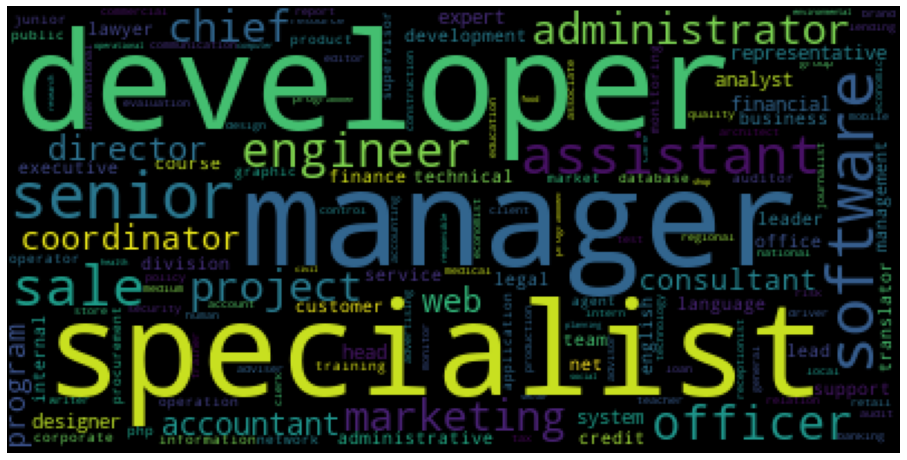

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Job nature changing overtime

In [23]:
len(data_lemmatized)

18973